In [27]:
# Importing libraries I need

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,make_scorer,recall_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [28]:
# Loading the dataset

data = pd.read_csv('Dataset/healthcare-dataset-stroke-data.csv')
data.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


From the above information, we can see that the column bmi has 4909 entries out of the 5110 which may mean that it has missing values.Let's confirm if it does

In [30]:
data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

There are 201 missing entries in the bmi.This is close to 4% of the values in that column that are missing.This is quite a small percentage of missing values so we can drop them

In [31]:
data.dropna(subset=['bmi'],inplace=True)

In [32]:
data.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Now there are no missing values

Checking for duplicates

In [33]:
data.duplicated().sum()

0

There are no duplicated values in the dataset

<Axes: >

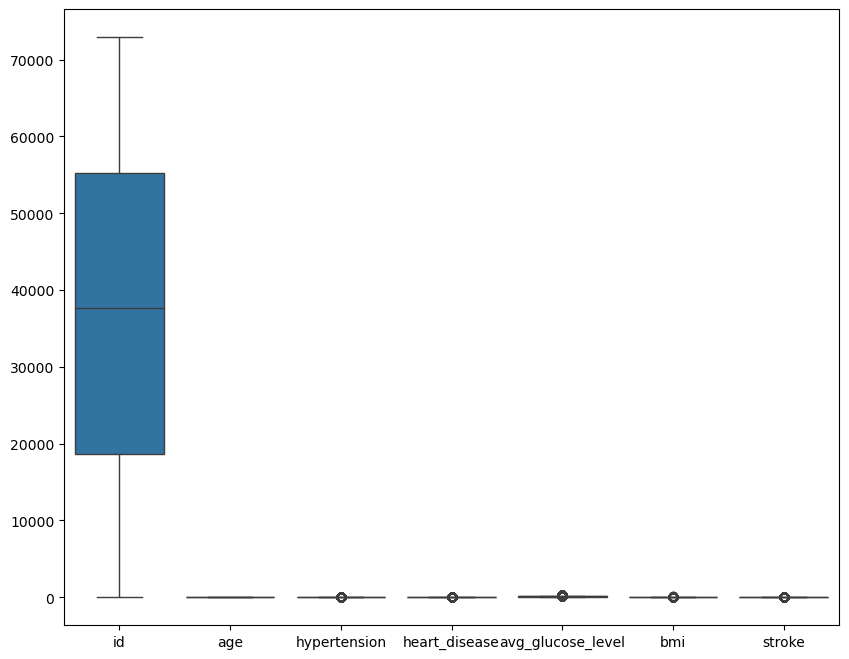

In [34]:
# Checking for outliers

plt.figure(figsize=(10,8))
sns.boxplot(data)



The data has no outliers

In [35]:
# Dropping id column as it does not have much impact on the target variable

data.drop(columns=['id'],inplace=True)

In [36]:
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [37]:
data['gender'].value_counts()

gender
Female    2897
Male      2011
Other        1
Name: count, dtype: int64

Gender other is only one out of all the gender values.This may have a very minute effect on our dataset hence let's drop it

In [38]:
data.drop(data[data['gender'] == 'Other'].index,axis=0,inplace=True)

In [39]:
# Confirming if the row has been dropped

data['gender'].value_counts()

gender
Female    2897
Male      2011
Name: count, dtype: int64

In [40]:
# Converting age column to int from float

data['age'] = data['age'].astype(int)

In [41]:
# Checking for class imbalance

data['stroke'].value_counts(normalize=True)*100

stroke
0    95.741646
1     4.258354
Name: proportion, dtype: float64

In this data, most people have no stroke as this category has carried 95% of the dataset.This may bring bias to our model so let's try correct it .

Text(0.5, 0, 'Stroke')

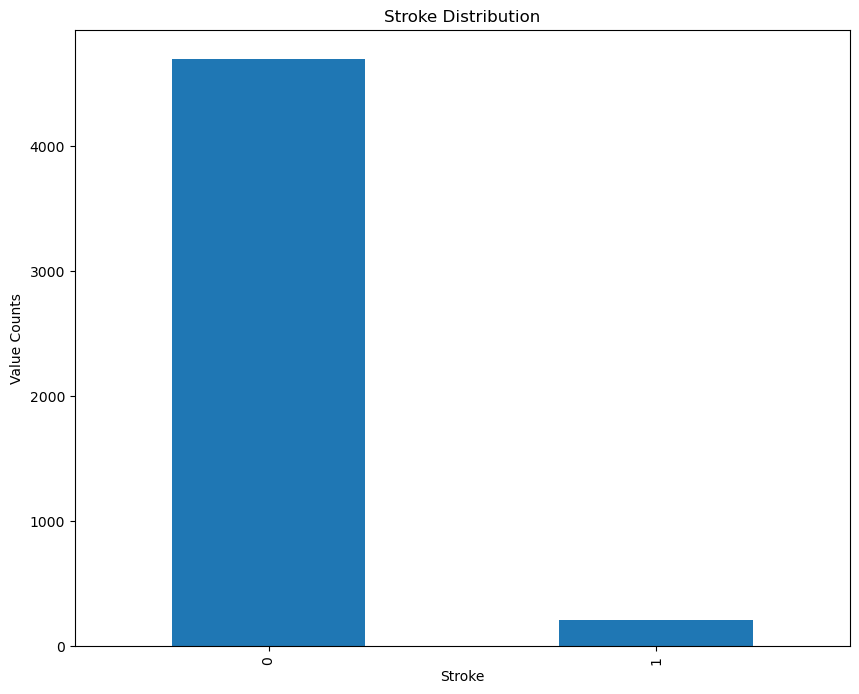

In [42]:
data['stroke'].value_counts().plot(kind='bar',figsize=(10,8),title='Stroke Distribution')
plt.ylabel('Value Counts')
plt.xlabel('Stroke')

### ONE-HOT ENCODING

The model can not take categorical data so we have to encode so that it can be input to the model

In [43]:
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,Female,13,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,Female,81,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [44]:
data['work_type'].value_counts()

work_type
Private          2810
Self-employed     775
children          671
Govt_job          630
Never_worked       22
Name: count, dtype: int64

In [45]:
# Splitting into train and test
X = data.drop(columns=['stroke'])
y = data['stroke']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [46]:
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,Female,13,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,Female,81,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [47]:
# Encoding using pd.get dummies

X_train_encoded = pd.get_dummies(X_train,columns=['gender','ever_married','work_type','Residence_type','smoking_status'],drop_first=True)
X_test_encoded = pd.get_dummies(X_test,columns=['gender','ever_married','work_type','Residence_type','smoking_status'],drop_first=True)

In [48]:
# Converting true and false to 1 and 0 respectively
pd.set_option('future.no_silent_downcasting',True)

X_train_encoded.replace({True:1,False:0},inplace=True)
X_test_encoded.replace({True:1,False:0},inplace=True)

In [49]:
X_test_encoded

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
4857,32,0,0,102.13,32.3,1,1,0,1,0,0,0,0,1,0
3709,42,0,0,84.03,31.4,0,0,0,1,0,0,1,0,1,0
964,66,1,0,74.90,32.1,1,1,0,1,0,0,0,0,1,0
2971,21,0,0,71.06,25.3,0,0,0,1,0,0,0,1,0,0
3262,47,0,0,88.49,22.2,1,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,22,0,0,58.38,36.0,1,0,0,1,0,0,0,0,1,0
205,78,0,0,106.74,33.0,0,1,0,1,0,0,1,1,0,0
3838,56,0,0,122.73,37.5,1,1,0,0,1,0,1,1,0,0
4524,56,0,0,144.33,29.2,0,1,0,1,0,0,1,0,1,0


Our data is now ready to fit into the model

#### MODELLING

In [50]:
# Correcting class imbalance
smote = SMOTE(random_state=42)

X_train_resampled,y_train_resampled = smote.fit_resample(X_train_encoded.values,y_train)

# Training random forest on the resampled data
lr = LogisticRegression(random_state=42,max_iter=1000)

# Fitting the model
lr.fit(X_train_resampled,y_train_resampled)

# Predicting the data
prediction = lr.predict(X_test_encoded.values)

# Evaluation metrics
print(f"Recall Score: {recall_score(y_test,prediction)}")

Recall Score: 0.7924528301886793


Our model is performing quite well from the precision score results. The Logistic Regression is able to identify actual positive instances(Stroke instances) out of the total predictions

#### DEPLYOMENT

In [51]:
# Using pickle to serialize/deserialize

import joblib

joblib.dump(X_train_resampled,'X_train_resampled.pkl')
joblib.dump(X_test_encoded,'X_test_encoded.pkl')
joblib.dump(y_train_resampled,'y_train_resampled.pkl')
joblib.dump(y_test,'y_test.pkl')
joblib.dump(lr,'lr.pkl')

['lr.pkl']

In [52]:
# Writing the model.py file

code = """ 
import joblib
X_train_resampled = joblib.load('X_train_resampled.pkl')
X_test_encoded = joblib.load('X_test_encoded.pkl')
y_train_resampled = joblib.load('y_train_resampled.pkl')
y_test = joblib.load('y_test.pkl')
lr = joblib.load('lr.pkl')

# Making predictions
predictions = lr.predict(X_test_encoded)
"""

with open ("model.py",'w') as f:
    f.write(code)
